In [1]:
import pickle
import os
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import approx_fprime
from numpy.linalg import norm
from sklearn.svm import SVC,LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import rbf_kernel


In [2]:

data = pd.read_csv("nonlineardata.csv", header=None)

In [24]:
X = np.array(data.iloc[:, :2])
print(len(data))
y = np.array(data.iloc[:, -1]).T
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,random_state=2022, train_size=0.8)
print(len(Xtrain), len(Xtest))

400
320 80


In [4]:
def plotClassifier(model, X, y):
    """plots the decision boundary of the model and the scatterpoints
       of the target values 'y'.

    Assumptions
    -----------
    y : it should contain two classes: '1' and '2'

    Parameters
    ----------
    model : the trained model which has the predict function

    X : the N by D feature array

    y : the N element vector corresponding to the target values

    """
    x1 = X[:, 0]
    x2 = X[:, 1]

    x1_min, x1_max = int(x1.min()) - 1, int(x1.max()) + 1
    x2_min, x2_max = int(x2.min()) - 1, int(x2.max()) + 1

    x1_line =  np.linspace(x1_min, x1_max, 200)
    x2_line =  np.linspace(x2_min, x2_max, 200)

    x1_mesh, x2_mesh = np.meshgrid(x1_line, x2_line)

    mesh_data = np.c_[x1_mesh.ravel(), x2_mesh.ravel()]

    y_pred = model.predict(mesh_data)
    y_pred = np.reshape(y_pred, x1_mesh.shape)

    plt.figure()
    plt.xlim([x1_mesh.min(), x1_mesh.max()])
    plt.ylim([x2_mesh.min(), x2_mesh.max()])

    plt.contourf(x1_mesh, x2_mesh, -y_pred.astype(int), # unsigned int causes problems with negative sign... o_O
                cmap=plt.cm.RdBu, alpha=0.6)


    y_vals = np.unique(y)
    plt.scatter(x1[y==y_vals[0]], x2[y==y_vals[0]], color="b", label="class %+d" % y_vals[0])
    plt.scatter(x1[y==y_vals[1]], x2[y==y_vals[1]], color="r", label="class %+d" % y_vals[1])
    plt.legend()

In [5]:
def savefig(fname, verbose=True):
    path = os.path.join('..', 'figs', fname)
    plt.savefig(path)
    if verbose:
        print("Figure saved as '{}'".format(path))

In [6]:
def check_gradient(model, X, y, dimensionality, verbose=True):
    # This checks that the gradient implementation is correct
    w = np.random.rand(dimensionality)
    f, g = model.funObj(w, X, y)

    # Check the gradient
    estimated_gradient = approx_fprime(w,
                                       lambda w: model.funObj(w,X,y)[0],
                                       epsilon=1e-6)

    implemented_gradient = model.funObj(w, X, y)[1]

    if np.max(np.abs(estimated_gradient - implemented_gradient) > 1e-3):
        raise Exception('User and numerical derivatives differ:\n%s\n%s' %
             (estimated_gradient[:5], implemented_gradient[:5]))
    else:
        if verbose:
            print('User and numerical derivatives agree.')

In [7]:
def findMin(funObj, w, maxEvals, *args, verbose=0):
    """
    Uses gradient descent to optimize the objective function

    This uses quadratic interpolation in its line search to
    determine the step size alpha
    """
    # Parameters of the Optimization
    optTol = 1e-2
    gamma = 1e-4

    # Evaluate the initial function value and gradient
    f, g = funObj(w,*args)
    funEvals = 1

    alpha = 1.
    while True:
        # Line-search using quadratic interpolation to 
        # find an acceptable value of alpha
        gg = g.T.dot(g)

        while True:
            w_new = w - alpha * g
            f_new, g_new = funObj(w_new, *args)

            funEvals += 1
            if f_new <= f - gamma * alpha*gg:
                break

            if verbose > 1:
                print("f_new: %.3f - f: %.3f - Backtracking..." % (f_new, f))

            # Update step size alpha
            alpha = (alpha**2) * gg/(2.*(f_new - f + alpha*gg))

        # Print progress
        if verbose > 0:
            print("%d - loss: %.3f" % (funEvals, f_new))

        # Update step-size for next iteration
        y = g_new - g
        alpha = -alpha*np.dot(y.T,g) / np.dot(y.T,y)

        # Safety guards
        if np.isnan(alpha) or alpha < 1e-10 or alpha > 1e10:
            alpha = 1.

        if verbose > 1:
            print("alpha: %.3f" % (alpha))

        # Update parameters/function/gradient
        w = w_new
        f = f_new
        g = g_new

        # Test termination conditions
        optCond = norm(g, float('inf'))

        if optCond < optTol:
            if verbose:
                print("Problem solved up to optimality tolerance %.3f" % optTol)
            break

        if funEvals >= maxEvals:
            if verbose:
                print("Reached maximum number of function evaluations %d" % maxEvals)
            break

    return w, f

In [8]:
def log_1_plus_exp_safe(x):
    # compute log(1+exp(x)) in a numerically safe way, avoiding overflow/underflow issues
    out = np.log(1+np.exp(x))
    out[x > 100] = x[x>100]
    out[x < -100] = np.exp(x[x < -100])
    return out

In [9]:
def kernel_linear(X1, X2):
    return X1@X2.T

In [10]:
class kernelLogRegL2():
    def __init__(self, lammy=1.0, verbose=0, maxEvals=100, kernel_fun=kernel_linear, **kernel_args):
        self.verbose = verbose
        self.lammy = lammy
        self.maxEvals = maxEvals
        self.kernel_fun = kernel_fun
        self.kernel_args = kernel_args

    def funObj(self, u, K, y):
        yKu = y * (K@u)

        # Calculate the function value
        # f = np.sum(np.log(1. + np.exp(-yKu)))
        f = np.sum(log_1_plus_exp_safe(-yKu))

        # Add L2 regularization
        f += 0.5 * self.lammy * u.T@K@u

        # Calculate the gradient value
        res = - y / (1. + np.exp(yKu))
        g = (K.T@res) + self.lammy * K@u

        return f, g


    def fit(self, X, y):
        n, d = X.shape
        self.X = X

        K = self.kernel_fun(X,X, **self.kernel_args)

        check_gradient(self, K, y, n, verbose=self.verbose)
        self.u, f = findMin(self.funObj, np.zeros(n), self.maxEvals, K, y, verbose=self.verbose)

    def predict(self, Xtest):
        Ktest = self.kernel_fun(Xtest, self.X, **self.kernel_args)
        return np.sign(Ktest@self.u)

In [11]:
def euclidean_dist_squared(X, Xtest):
    """Computes the Euclidean distance between rows of 'X' and rows of 'Xtest'

    Parameters
    ----------
    X : an N by D numpy array
    Xtest: an T by D numpy array
    """

    # add extra dimensions so that the function still works for X and/or Xtest are 1-D arrays.
    if X.ndim == 1:
        X = X[None]
    if Xtest.ndim == 1:
        Xtest = Xtest[None]

    return np.sum(X**2, axis=1)[:,None] + np.sum(Xtest**2, axis=1)[None] - 2 * np.dot(X,Xtest.T)

In [12]:
def kernel_RBF(X1, X2, sigma=1):

    K = np.exp(- euclidean_dist_squared(X1, X2) / (sigma**2))

    return K

def kernel_poly(X1, X2, p=2):
    prod = X1@X2.T
    prod = prod + 1
    return (prod)**p

Training error 0.188
Testing error 0.237


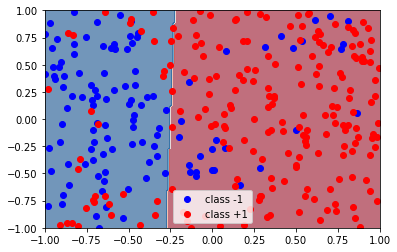

In [13]:
svm_linear = SVC(kernel='linear', C=100)
svm_linear.fit(Xtrain, ytrain)
plotClassifier(svm_linear, Xtrain, ytrain)
plt.savefig('svm_linear.png')
print("Training error %.3f" % np.mean(svm_linear.predict(Xtrain) != ytrain))
print("Testing error %.3f" % np.mean(svm_linear.predict(Xtest) != ytest))

Training error 0.172
Testing error 0.225


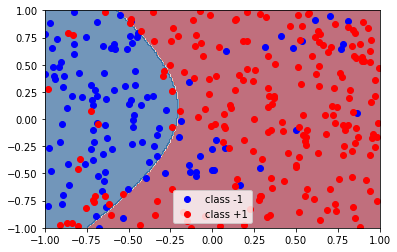

In [14]:
svm_poly = SVC(kernel='poly', C=100, gamma=1, coef0=1, degree=2)
svm_poly.fit(Xtrain, ytrain)
plotClassifier(svm_poly, Xtrain, ytrain)
plt.savefig('svm_poly.png')
print("Training error %.3f" % np.mean(svm_poly.predict(Xtrain) != ytrain))
print("Testing error %.3f" % np.mean(svm_poly.predict(Xtest) != ytest))

Training error 0.100
Testing error 0.150


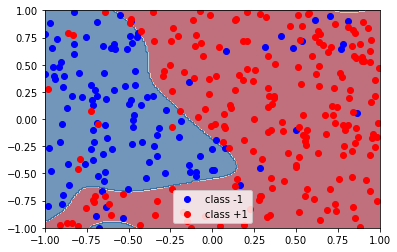

In [15]:
svm_rbf = SVC(kernel='rbf', C=100, gamma=4)
svm_rbf.fit(Xtrain, ytrain)
plotClassifier(svm_rbf, Xtrain, ytrain)
plt.savefig('svm_rbf.png')
print("Training error %.3f" % np.mean(svm_rbf.predict(Xtrain) != ytrain))
print("Testing error %.3f" % np.mean(svm_rbf.predict(Xtest) != ytest))

In [16]:
gammas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_errors = []
test_errors = []
for g in gammas:
    rbf_svc = SVC(kernel='rbf', C=100, gamma=g)
    rbf_svc.fit(Xtrain, ytrain)
    train_err = np.mean(rbf_svc.predict(Xtrain) != ytrain)
    test_err = np.mean(rbf_svc.predict(Xtest) != ytest)
    train_errors.append(train_err)
    test_errors.append(test_err)
    print("Training error %.3f" % train_err)
    print("Testing error %.3f" % test_err)

Training error 0.222
Testing error 0.287
Training error 0.200
Testing error 0.212
Training error 0.188
Testing error 0.237
Training error 0.163
Testing error 0.150
Training error 0.113
Testing error 0.138
Training error 0.069
Testing error 0.150
Training error 0.006
Testing error 0.138
Training error 0.000
Testing error 0.362


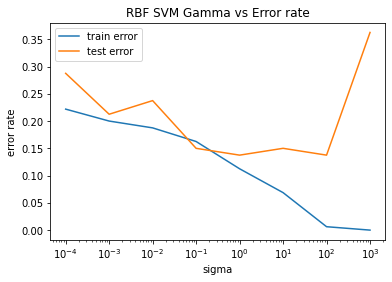

In [17]:
plt.figure()
plt.xlabel('sigma')
plt.ylabel('error rate')
plt.plot(gammas, train_errors, label='train error')
plt.plot(gammas, test_errors, label='test error')
plt.xscale('log')
plt.title('RBF SVM Gamma vs Error rate')
plt.legend()
plt.savefig("svm_gamma_err.png")
plt.show()

<ipython-input-8-70f6bfaf7841>:3: RuntimeWarning: overflow encountered in exp
  out = np.log(1+np.exp(x))
<ipython-input-10-f66386ab200c>:20: RuntimeWarning: overflow encountered in exp
  res = - y / (1. + np.exp(yKu))


Training error 0.237
Testing error 0.237


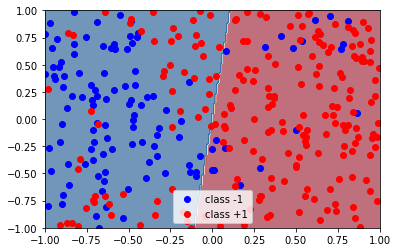

In [18]:
lr_linear = kernelLogRegL2(kernel_fun=kernel_linear, lammy=0.01)
lr_linear.fit(Xtrain, ytrain)
plotClassifier(lr_linear, Xtrain, ytrain)
plt.savefig('lr_linear.png')
print("Training error %.3f" % np.mean(lr_linear.predict(Xtrain) != ytrain))
print("Testing error %.3f" % np.mean(lr_linear.predict(Xtest) != ytest))

<ipython-input-8-70f6bfaf7841>:3: RuntimeWarning: overflow encountered in exp
  out = np.log(1+np.exp(x))
<ipython-input-10-f66386ab200c>:20: RuntimeWarning: overflow encountered in exp
  res = - y / (1. + np.exp(yKu))


Training error 0.184
Testing error 0.237


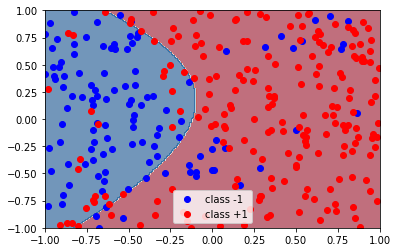

In [19]:
#Q4.2
lr_poly = kernelLogRegL2(kernel_fun=kernel_poly, lammy=0.01)
lr_poly.fit(Xtrain, ytrain)
plotClassifier(lr_poly, Xtrain, ytrain)
plt.savefig('lr_poly.png')
print("Training error %.3f" % np.mean(lr_poly.predict(Xtrain) != ytrain))
print("Testing error %.3f" % np.mean(lr_poly.predict(Xtest) != ytest))

<ipython-input-8-70f6bfaf7841>:3: RuntimeWarning: overflow encountered in exp
  out = np.log(1+np.exp(x))
<ipython-input-10-f66386ab200c>:20: RuntimeWarning: overflow encountered in exp
  res = - y / (1. + np.exp(yKu))


Training error 0.113
Testing error 0.150


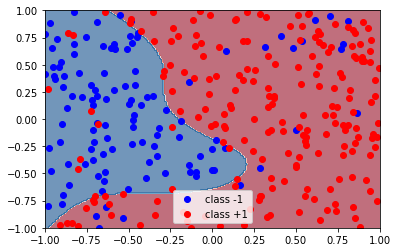

In [20]:
lr_rbf = kernelLogRegL2(kernel_fun=kernel_RBF, lammy=0.01, sigma=0.5)
lr_rbf.fit(Xtrain, ytrain)
plotClassifier(lr_rbf, Xtrain, ytrain)
plt.savefig('lr_rbf.png')
print("Training error %.3f" % np.mean(lr_rbf.predict(Xtrain) != ytrain))
print("Testing error %.3f" % np.mean(lr_rbf.predict(Xtest) != ytest))

In [21]:
gammas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_errors = []
test_errors = []
for g in gammas:
    rbf_lr = kernelLogRegL2(kernel_fun=kernel_RBF, lammy=0.01, sigma=np.sqrt(1/g))
    rbf_lr.fit(Xtrain, ytrain)
    train_err = np.mean(rbf_lr.predict(Xtrain) != ytrain)
    test_err = np.mean(rbf_lr.predict(Xtest) != ytest)
    train_errors.append(train_err)
    test_errors.append(test_err)
    print("Training error %.3f" % train_err)
    print("Testing error %.3f" % test_err)

<ipython-input-8-70f6bfaf7841>:3: RuntimeWarning: overflow encountered in exp
  out = np.log(1+np.exp(x))
<ipython-input-10-f66386ab200c>:20: RuntimeWarning: overflow encountered in exp
  res = - y / (1. + np.exp(yKu))


Training error 0.309
Testing error 0.338
Training error 0.188
Testing error 0.250
Training error 0.203
Testing error 0.250
Training error 0.181
Testing error 0.263
Training error 0.147
Testing error 0.113
Training error 0.103
Testing error 0.113
Training error 0.016
Testing error 0.200
Training error 0.000
Testing error 0.175


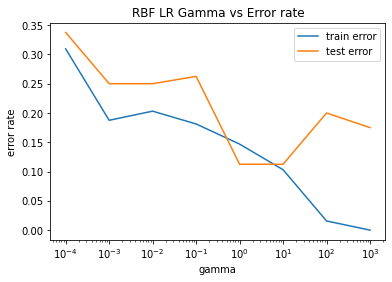

In [22]:
plt.figure()
plt.xlabel('gamma')
plt.ylabel('error rate')
plt.plot(gammas, train_errors, label='train error')
plt.plot(gammas, test_errors, label='test error')
plt.xscale('log')
plt.title('RBF LR Gamma vs Error rate')
plt.legend()
plt.savefig("lr_gamma_err.png")
plt.show()